<h1> MBA Zero Byte Analysis</h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

In [1]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [24]:
%%toggle_code
import os
import pandoc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline


print('Executed')

In [3]:
def dfNormalizer(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    total_boxes = df['total_boxes']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty, total_boxes=total_boxes))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

In [4]:
def removeTiersWithLimitedResults(df, limNum):
    df = df
    series= df['ispTech'].value_counts()
    limNum = limNum
    outList = []
    i = 0
    
    while i < len(series):
        for count in series:
            if count != limNum:
                outList.append(series.index[i])
            i+=1
            
    outDF = df[~df['ispTech'].isin(outList)]

    return outDF

<h3> Raw MBA June Data

<h4> Download results with concurrent TCP connections June 2021 (Raw)

In [5]:
raw_download_jun2021 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2021` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2021` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_jun2021 = client.query(raw_download_jun2021).to_dataframe()
print("executed")
print("raw dataset from June 2021")


executed
raw dataset from June 2021


<h4> Zero byte speed results June 2021 (Raw)

In [6]:
junZeroByteSQL = """
SELECT
  mt.Unit_ID as unitID,
  mt.download as downloadTier,
  mt.ISP as ISP,
  mt.Technology as tech,
  httpmt.bytes_sec as bytesSec,
  httpmt.dtime as testDtime,
  
FROM
  `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
INNER JOIN
  `broadband-data.mba_data.unit-profile-sept2021` as mt ON httpmt.unit_id=mt.Unit_ID
--WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
WHERE (httpmt.bytes_sec = 0)
GROUP BY unitID, downloadTier, ISP, tech,  bytesSec, testDtime
ORDER BY mt.Download
"""
junZeroByteDF = client.query(junZeroByteSQL).to_dataframe()
print("executed")
print("Zero byte June 2021 table")


executed
Zero byte June 2021 table


<h4> UDP Loss June 2021 (Raw)

In [7]:
udpcLossSQLJUN2021 = """
SELECT 
    count(*) as totalOutages, 
    mt.ISP as ISP, 
    mt.Technology as tech, 
    mt.Download as DownloadTier, 
    avg(udploss.duration/1000) as avgOutageMs, 
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMs,
    avg(udploss.packets) as avgPacketLoss, 
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
    COUNT(DISTINCT mt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_udpclossRawJun2021` as udploss 
    INNER JOIN `broadband-data.mba_data.unit-profile-sept2021` as mt ON udploss.unit_id=mt.Unit_ID
    --WHERE (EXTRACT(HOUR FROM udploss.dtime) >= 19) AND (EXTRACT(HOUR FROM udploss.dtime) <=23)
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING COUNT(DISTINCT mt.unit_id) > 29
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""
rawJun21UDPCLoss = client.query(udpcLossSQLJUN2021).to_dataframe()
print("executed")
print("UDPC Loss June 2021 table")

executed
UDPC Loss June 2021 table


<h3> Preprocessing

In [8]:
raw_download_jun2021 = dfNormalizer(raw_download_jun2021)

In [9]:
rawJun21UDPCLoss.rename(columns={'DownloadTier': 'tier', 'ISP':'isp'}, inplace=True)
rawJun21UDPCLoss['month'] = 'Jun2021'
junCols = rawJun21UDPCLoss.columns.difference(raw_download_jun2021.columns)
rawMBAJun21 = pd.merge(raw_download_jun2021, rawJun21UDPCLoss[junCols],left_index=True, 
                      right_index=True, how='outer').dropna()

In [10]:
junZeroByteDF = junZeroByteDF.rename(columns = {"downloadTier": "tier", "ISP": "isp", "bytesSec":"0ByteResults"})


In [11]:
uniBoxes = junZeroByteDF.groupby(["tier", "isp", 'tech'], as_index=False)["unitID"].nunique()
uniBoxes = uniBoxes['unitID']
junZeroByteGroupDF = junZeroByteDF.groupby(["tier", "isp", "tech"], as_index=False)["0ByteResults"].count()
junZeroByteGroupDF = junZeroByteGroupDF.join(uniBoxes)
junZeroByteGroupDF = junZeroByteGroupDF.rename(columns = {"unitID": "total_boxes"})
mask = junZeroByteGroupDF['total_boxes'] > 29
junZeroByteGroupDF=junZeroByteGroupDF[mask]
junZeroByteGroupDF

,tier,isp,tech,0ByteResults,total_boxes
64,100.0,Comcast,Cable,3260,30
67,100.0,Mediacom,Cable,4405,39
73,150.0,Cox,Cable,4803,40
76,200.0,Charter,Cable,6580,55
77,200.0,Comcast,Cable,6928,57
90,400.0,Charter,Cable,6125,59
91,400.0,Comcast,Cable,6623,48
93,500.0,Cincinnati Bell,Fiber,9074,72
112,1200.0,Comcast,Cable,4121,46


In [12]:
rawMBAJun21 = pd.merge(rawMBAJun21, junZeroByteGroupDF, on=["isp", 'tier','tech'], how="left").dropna()

In [13]:
rawMBAJun21

,tier,ispTech,tech,isp,avg,median,twentypct,fivepct,eightyeighty,total_boxes_x,...,avgPacketLoss,fifthPctPacketLoss,fifthpctOutageMs,medianOutageMs,medianPacketLoss,month,totalOutages,twentyPctOutageMs,0ByteResults,total_boxes_y
18,100.0,100\nComcast\nCable,Cable,Comcast,113.184407,118.768488,112.237720,84.621208,109.573184,48.0,...,135.481068,22,33941.657,4618.589,2,Jun2021,23743,7500.684,3260.0,30.0
19,100.0,100\nMediacom\nCable,Cable,Mediacom,122.856583,132.530688,118.211152,78.382256,109.823014,41.0,...,33.780458,11,18006.354,4506.117,2,Jun2021,42903,7496.845,4405.0,39.0
22,150.0,150\nCox\nCable,Cable,Cox,107.159905,117.306928,105.385536,42.435925,93.889815,49.0,...,11.008193,61,93001.500,5996.439,3,Jun2021,4394,10716.839,4803.0,40.0
23,200.0,200\nCharter\nCable,Cable,Charter,109.013761,116.618828,112.131008,57.791756,101.502490,85.0,...,289.286972,135,180001.437,6000.024,3,Jun2021,4429,16499.050,6580.0,55.0
24,200.0,200\nComcast\nCable,Cable,Comcast,110.765554,118.587396,112.008376,46.967780,106.266951,67.0,...,105.883968,16,27371.000,4507.727,2,Jun2021,29785,7496.932,6928.0,57.0
27,400.0,400\nCharter\nCable,Cable,Charter,107.931085,119.212266,102.628218,26.656054,86.521679,74.0,...,23.066240,9,15519.696,4503.024,2,Jun2021,30782,6005.147,6125.0,59.0
28,400.0,400\nComcast\nCable,Cable,Comcast,108.055935,117.673622,107.895748,52.060972,89.967683,53.0,...,116.685835,24,38243.467,4504.573,2,Jun2021,8295,15582.351,6623.0,48.0
29,500.0,500\nCincinnati Bell\nFiber,Fiber,Cincinnati Bell,83.515939,82.623701,67.119112,18.797576,63.079909,108.0,...,107.546607,34,55502.531,4512.166,2,Jun2021,13410,7504.538,9074.0,72.0
32,1200.0,1200\nComcast\nCable,Cable,Comcast,68.483508,75.974903,61.048759,36.403242,49.933965,58.0,...,314.692621,93,135116.501,5974.878,3,Jun2021,4906,16567.714,4121.0,46.0


<h3> Results and tables

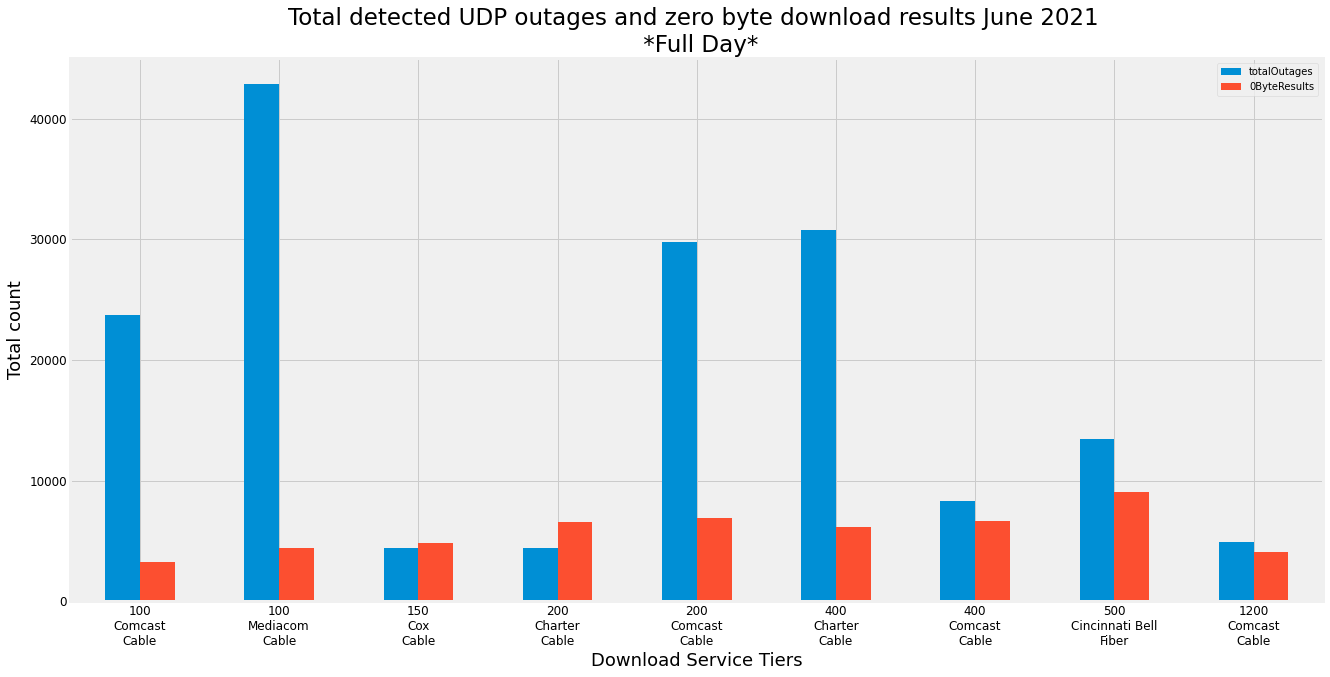

In [14]:
ax = rawMBAJun21.plot(x = "ispTech", y = [ 'totalOutages', '0ByteResults'],  kind = 'bar', stacked = False, 
                   fontsize = 12, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Total count', fontsize=18)
ax.set_title('Total detected UDP outages and zero byte download results June 2021 \n *Full Day*', fontsize=23)



plt.show()

<h3> Specific Tier analysis 

In [15]:
junZeroByteDF

,unitID,tier,isp,tech,0ByteResults,testDtime
0,25755017,1.0,Frontier,DSL,0,2021-06-02 00:37:04+00:00
1,3880549,1.5,CenturyLink,DSL,0,2021-06-22 06:47:42+00:00
2,3880549,1.5,CenturyLink,DSL,0,2021-06-10 18:46:20+00:00
3,3880549,1.5,CenturyLink,DSL,0,2021-06-19 06:47:18+00:00
4,3880549,1.5,CenturyLink,DSL,0,2021-06-10 06:46:56+00:00
...,...,...,...,...,...,...
100167,36691909,1200.0,Comcast,Cable,0,2021-06-27 12:59:30+00:00
100168,36691909,1200.0,Comcast,Cable,0,2021-06-30 02:01:58+00:00
100169,40729909,1200.0,Comcast,Cable,0,2021-06-09 05:43:40+00:00
100170,38659053,1200.0,Comcast,Cable,0,2021-06-08 02:58:20+00:00


In [16]:
x = 0
def time2int(junZeroByteDF):
    for time in junZeroByteDF['testDtime']:
        junZeroByteDF['dTimeInt'] = time.value
    return junZeroByteDF
    
    
   

In [17]:
junZeroByteDF = time2int(junZeroByteDF)
junZeroByteDF

,unitID,tier,isp,tech,0ByteResults,testDtime,dTimeInt
0,25755017,1.0,Frontier,DSL,0,2021-06-02 00:37:04+00:00,1624435433000000000
1,3880549,1.5,CenturyLink,DSL,0,2021-06-22 06:47:42+00:00,1624435433000000000
2,3880549,1.5,CenturyLink,DSL,0,2021-06-10 18:46:20+00:00,1624435433000000000
3,3880549,1.5,CenturyLink,DSL,0,2021-06-19 06:47:18+00:00,1624435433000000000
4,3880549,1.5,CenturyLink,DSL,0,2021-06-10 06:46:56+00:00,1624435433000000000
...,...,...,...,...,...,...,...
100167,36691909,1200.0,Comcast,Cable,0,2021-06-27 12:59:30+00:00,1624435433000000000
100168,36691909,1200.0,Comcast,Cable,0,2021-06-30 02:01:58+00:00,1624435433000000000
100169,40729909,1200.0,Comcast,Cable,0,2021-06-09 05:43:40+00:00,1624435433000000000
100170,38659053,1200.0,Comcast,Cable,0,2021-06-08 02:58:20+00:00,1624435433000000000


In [18]:
charter400Jun21 = junZeroByteDF[(junZeroByteDF['tier'] == 400) & (junZeroByteDF['isp'] == "Charter")]

In [19]:
charter400Jun21 = charter400Jun21.groupby(["unitID"]).describe()

In [20]:
comcast400Jun21 = junZeroByteDF[(junZeroByteDF['tier'] == 400) & (junZeroByteDF['isp'] == "Comcast")]

In [21]:
comcast400Jun21 = comcast400Jun21.groupby(["unitID"]).describe()

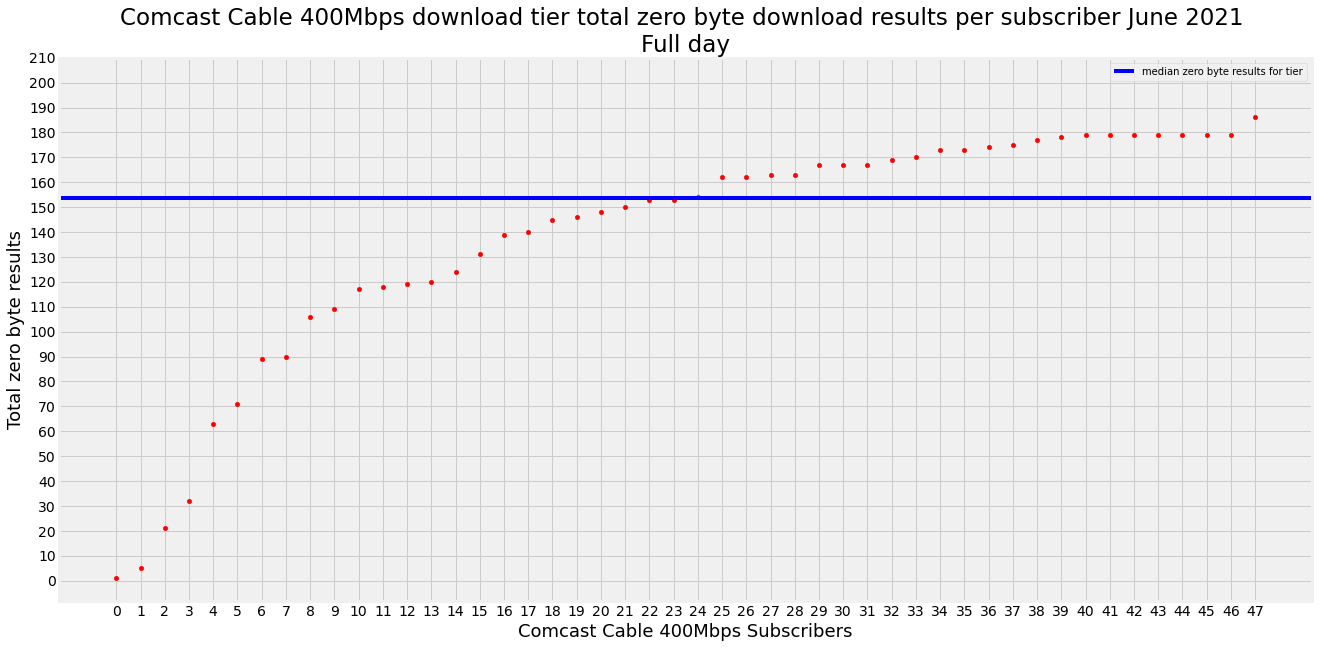

In [22]:
zeroByteResults = comcast400Jun21[('0ByteResults', 'count')]
zeroByteResults = zeroByteResults.sort_values()
zeroByteResults = zeroByteResults.to_frame().reset_index()

x=[]
for i in range(len(zeroByteResults)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['0ByteResults'] = zeroByteResults[('0ByteResults','count')]
chartData['Subscribers'] = x


ax = chartData.plot(x = 'Subscribers' ,y = '0ByteResults',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r")

median = chartData['0ByteResults'].median()
plt.yticks(np.arange(0, 220, 10))
plt.xticks(np.arange(0, len(zeroByteResults), 1))
plt.axhline(y = median, color = 'blue', linestyle = '-', label = "median zero byte results for tier")

ax.set_xlabel('Comcast Cable 400Mbps Subscribers', fontsize=18)
ax.set_ylabel('Total zero byte results', fontsize=18)
ax.set_title('Comcast Cable 400Mbps download tier total zero byte download results per subscriber June 2021 \nFull day', fontsize=23)

plt.legend()


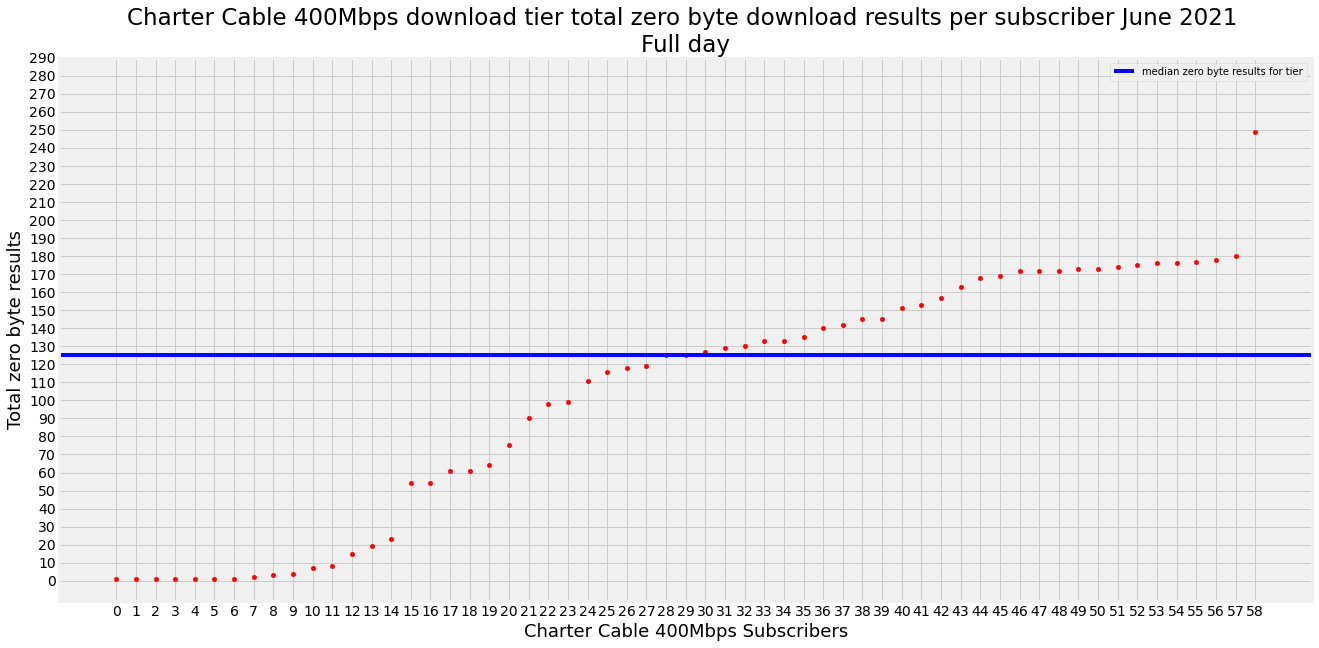

In [23]:
zeroByteResults = charter400Jun21[('0ByteResults', 'count')]
zeroByteResults = zeroByteResults.sort_values()
zeroByteResults = zeroByteResults.to_frame().reset_index()

x=[]
for i in range(len(zeroByteResults)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['0ByteResults'] = zeroByteResults[('0ByteResults','count')]
chartData['Subscribers'] = x


ax = chartData.plot(x = 'Subscribers' ,y = '0ByteResults',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r")

median = chartData['0ByteResults'].median()
plt.yticks(np.arange(0, 300, 10))
plt.xticks(np.arange(0, len(zeroByteResults), 1))
plt.axhline(y = median, color = 'blue', linestyle = '-', label = "median zero byte results for tier")

ax.set_xlabel('Charter Cable 400Mbps Subscribers', fontsize=18)
ax.set_ylabel('Total zero byte results', fontsize=18)
ax.set_title('Charter Cable 400Mbps download tier total zero byte download results per subscriber June 2021 \nFull day', fontsize=23)

plt.legend()
